# Find the Maximum Common Substructure, and Groups Off It, Between a Set of Molecules Using RDKit

In drug discovery, the lead optimization step often involves creating analogues of a hit (a promising compound which produces a desired result in an assay) to optimize selectivity and minimize toxicity. Because it is typically easier to chemically modify the periphery of the molecule (for example the functional groups) than the scaffold, it is helpful to compare the groups off of the common scaffold. This utility function uses RDKit to find the maximum common substructure (MCS) between a set of molecules, then show the groups off of that MCS.

In a previous blog post, I [found and highlighted the maximum common substructure (MCS) between a set of molecules]({% post_url 2022-10-09-RDKit-find-and-highlight-the-maximum-common-substructure-between-molecules %}) by creating a function `SmilesMCStoGridImage` using RDKit. This post takes it a step further by optionally identifying and showing the groups off the MCS. These might be R groups off a core scaffold.

Here's an example, annotated to explain the grid arrangement:

![Grid of maximum common substructure and core; molecules and groups off maximum common substructure](../images/pyridinols-MCS-groups-annotated.png)

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2022-12-25-RDKit-Find-Groups-Off-Common-Core.ipynb)*

To show the groups off of the MCS, the grid of molecular images is two-dimensional:
- The first row is the MCS (as first SMARTS match, then as a molecule referred to as the core)
- Each subsequent row represents an input molecule
    - The first item in the row is the input molecule
    - Each subsequent item is a group off of the MCS, sorted by the core atom the group is attached to

The key RDKit commands it uses are:
- [`ReplaceCore`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.ReplaceCore) to mask out the MCS in each molecule
- [`GetMolFrags`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.GetMolFrags) to get the molecular fragments (groups) off of the MCS
- [`FindMCS`](https://www.rdkit.org/docs/source/rdkit.Chem.rdFMCS.html) to find the maximum common substructure (SMARTS string)
- [`MolFromSmarts`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html) to generate a molecule corresponding to the maximum common substructure
- [`GenerateDepictionMatching2DStructure`](http://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html) to align the matching substructure
- [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) to draw the grid of the MCS, the molecules with that MCS highlighted, and the groups off of the MCS for each molecule

You can think of the core as the materialized MCS. That is, the MCS is a substructure match (SMARTS), and the core is a structure (SMILES). For example, on the right side of the MCS, off the aromatic ring is a nitrogen atom, N. The analogous part of the core materializes that nitrogen in the simplest possible way, into an amine group, NH<sub>2</sub>.

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
import re

In [2]:
# Utilities
def flatten_twoD_list(twoD_list: list[list]) -> list:
    flat_list = []
    for row in twoD_list:
        for item in row:
            flat_list += [item]
    return flat_list

def longest_row(twoD_list: list[list]) -> int:
    return max(len(row) for row in twoD_list)

def pad_rows(twoD_list: list[list], row_length: int, filler = "") -> list[list]:
    for row in twoD_list:
        padding = row_length - len(row)
        row += [filler] * padding
    return twoD_list

def label_zero_dummy_atom(frag: str) -> str:
    # Search for *l where l is a letter (atomic symbol)
    # Example inputs:
    #   Has dummy atom:   '[2*]C' stays the same
    #   Lacks dummy atom: '*CCC' -> '[0*]CCC', so want to replace '*' with '[0*]'

    # Search for pattern *l; returns an object if found, None if not found
    missing_dummy_atom = re.search('\*[a-zA-Z]', frag)

    if missing_dummy_atom:
        return frag.replace('*', '[0*]', 1)
    else:
        return frag

def extract_dummy_atom_number(frag: str) -> int:
    # Extract the dummy atom number from a fragment string
    # Examples: '[2*]C' -> 2, '[12*]C' -> 12
    bracket_n_star = re.search("\[\d+\*", frag)
    return int(bracket_n_star.group()[1:-1])

In [3]:
def SmilesMCStoGridImage(smiles: list[str] or dict[str, str], align_substructure: bool = True, groups: bool = False, useSVG: bool = False, verbose: bool = False, **kwargs):
     """
     Convert a list (or dictionary) of SMILES strings to an RDKit grid image of the maximum common substructure (MCS) match between them

     :returns: RDKit grid image, and (if verbose=True) MCS SMARTS string and molecule, and list of molecules for input SMILES strings
     :rtype: RDKit grid image, and (if verbose=True) string, molecule, and list of molecules
     :param smiles: The SMILES strings of the molecules to be compared and drawn
     :type smiles: List of (SMILES) strings, or dictionary of {(SMARTS) string: (legend) string} pairs
     :param align_substructure: Whether to align the MCS substructures when plotting the molecules; default is True
     :type align_substructure: boolean
     :param groups: Whether to show groups off the MCS in the grid of molecules; default is False
     :type groups: boolean
     :param useSVG: Whether to return an SVG (rather than PNG) image for the molecule grid; default is False
     :type useSVG: boolean
     :param verbose: Whether to return verbose output (MCS SMARTS string and molecule, and list of molecules for input SMILES strings); default is False so calling this function will present a grid image automatically
     :type verbose: boolean
     """

     mols = [Chem.MolFromSmiles(smile) for smile in smiles]
     frags = rdFMCS.FindMCS(mols, **kwargs)
     mcs_smarts = frags.smartsString
     mcs_mol = Chem.MolFromSmarts(mcs_smarts)

     mcs_legend = "Max. substructure match"

     # If user supplies a dictionary, use the values as legend entries for molecules
     if isinstance(smiles, dict):
          mol_smiles = [key for key in smiles.keys()]
          mol_legends = [smiles[molecule] for molecule in smiles]
     else:
          mol_smiles = smiles
          mol_legends = ["" for mol in mols]

     matches_mols = [mol.GetSubstructMatch(mcs_mol) for mol in mols]

     Chem.Compute2DCoords(mcs_mol)

     # Determine if user requested groups, and if they can be made (is there an MCS)
     if groups:
          if len(mcs_smarts) == 0:
               print("There is no maximum common substructure (MCS), so groups off the MCS cannot be created. This output reflects groups=False. If you want to find groups, please ensure the set of molecules has an MCS.")
               groups_exist = False
          else:
               groups_exist = True
     else:
          groups_exist = False

     # Include groups off core, using 2D grid
     if groups_exist:
          core_smiles_like_smarts = Chem.MolToSmiles(mcs_mol)
          core_mol = Chem.MolFromSmiles(core_smiles_like_smarts)
          core_smiles = Chem.MolToSmiles(core_mol)

          mcs_row_legend = [mcs_legend, 'Core']
          
          # Prepare 2D lists
          smiles_2D = []
          legends_2D = []
          matches_2D = []

          for mol_index, mol in enumerate(mols):
               # Replace core and get groups
               frags = Chem.ReplaceCore(mol, core_mol, labelByIndex=True)
               groups = Chem.GetMolFrags(frags, asMols = True)

               # Ensure any zero (0) dummy atoms are noted as such--RDKit apparently excludes 0 labels
               groups_smiles = [label_zero_dummy_atom(Chem.MolToSmiles(group)) for group in groups]

               # Sort groups by dummy atom number, so groups appear in a logical order
               groups_smiles.sort(key=extract_dummy_atom_number)

               # Set up 2D matrix (nested list):
               #    Max. substructure match   Core
               #    Molecule 1                Mol1Group1   Mol1Group2
               #    Molecule 2                Mol2Group1

               # Make smiles into 2D list with
               #   one molecule in each top-level list, then
               #   the groups off the MCS for that molecule
               smiles_2D += [[mol_smiles[mol_index], *groups_smiles]]

               # Make legends into 2D list; add SMILES for each group
               legends_2D += [[mol_legends[mol_index], *groups_smiles]]

               # Make matching atoms into 2D list
               matches_2D += [[matches_mols[mol_index]]]

          # Add MCS row and pad rows so MolsToGridImage will have one molecule (and its groups) per row
          longest_row = max(len(row) for row in smiles_2D)

          mcs_codes_2D = [[mcs_smarts, core_smiles_like_smarts]]
          mcs_codes_2D = pad_rows(mcs_codes_2D, longest_row)

          smiles_2D = pad_rows(smiles_2D, longest_row)

          # mcs_and_smiles_2D = [[mcs_smarts, core_smiles_like_smarts]] + smiles_2D
          # mcs_and_smiles_2D = pad_rows(mcs_and_smiles_2D, longest_row)

          legends_2D = [mcs_row_legend] + legends_2D
          legends_2D = pad_rows(legends_2D, longest_row)

          matches_2D = [[]] + matches_2D
          matches_2D = pad_rows(matches_2D, longest_row, ())

          # Generate MCS molecules from codes (SMARTS and SMILES)
          mcs_2D = []
          row_adding = []
          for item_index, item in enumerate(mcs_codes_2D[0]):
               # MCS is a SMARTS string
               if  item_index == 0:
                    row_adding += [Chem.MolFromSmarts(item)]
               # Core is SMILES string
               else:
                    row_adding += [Chem.MolFromSmiles(item)]
          mcs_2D += [row_adding]

          # Generate molecules from input molecules and groups (SMILES) in 2D list
          mols_2D = []
          for row_index, row in enumerate(smiles_2D):
               row_adding = []
               for item_index, item in enumerate(row):
                    row_adding += [Chem.MolFromSmiles(item)]
               mols_2D += [row_adding]

          mcs_and_mols_2D = mcs_2D + mols_2D

          # Reference core molecule for future use
          core_mcs_and_mols_2D = mcs_and_mols_2D[0][1]

          # Align cores if requested
          if align_substructure:
               subms = [core_mcs_and_mols_2D]
               for row_index, row in enumerate(mcs_and_mols_2D[1:]):
                    subms += [row[0]]

               Chem.Compute2DCoords(mcs_mol)

               for m in subms:
                    _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

          # Add atom numbers to core
          for atom in core_mcs_and_mols_2D.GetAtoms():
               # atom.SetProp("atomNote", str(atom.GetIdx())) # Can set atomNote to put atom index off to the side, but too small to read
               atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

          # Use MolsMatrixToGridImage if available in the installed version of RDKit
          try:
               drawing = Draw.MolsMatrixToGridImage(molsMatrix=mcs_and_mols_2D, legendsMatrix=legends_2D, highlightAtomListsMatrix=matches_2D, useSVG=useSVG)
          except AttributeError:
               # Convert 2D list back to 1D so MolsToGridImage can handle it
               mcs_and_mols = flatten_twoD_list(mcs_and_mols_2D)
               legends = flatten_twoD_list(legends_2D)
               matches = flatten_twoD_list(matches_2D)

               mcs_and_mols[0] = mcs_mol

               drawing = Draw.MolsToGridImage(mcs_and_mols, legends = legends, highlightAtomLists = matches, molsPerRow = longest_row, useSVG=useSVG)

     # Do not include groups off core, using 1D grid
     else:
          mcs_and_mols = [mcs_mol] + mols
          subms = [x for x in mcs_and_mols if x.HasSubstructMatch(mcs_mol)]
          legends = [mcs_legend] + mol_legends

          # Align cores if requested
          if align_substructure:
               for m in subms:
                    _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

          matches = [""] + matches_mols
          drawing = Draw.MolsToGridImage(mcs_and_mols, highlightAtomLists = matches, legends = legends, useSVG=useSVG)

     if verbose:
          # If user requested groups
          if groups:
               # If groups could be made, provide them
               if groups_exist:
                    return drawing, mcs_smarts, mcs_mol, mols_2D, core_smiles, core_mol
               # If groups could not be made, provide outputs matching output expected from groups=True, but with "empty" values for groups-related items
               else:
                    return drawing, mcs_smarts, mcs_mol, mols, "", None
          else:
               return drawing, mcs_smarts, mcs_mol, mols
     else:
          return drawing

## Small Example: Two Pyridinols

Let's take the example of pyridinols, as [Shchepin et al](https://pubmed.ncbi.nlm.nih.gov/24482730/) did. These are drug-like molecules which inhibit the cyclooxygenase (prostaglandin H<sub>2</sub> synthase) COX-1. That is the mechanism of action of acetaminophen, the active ingredient in Tylenol.

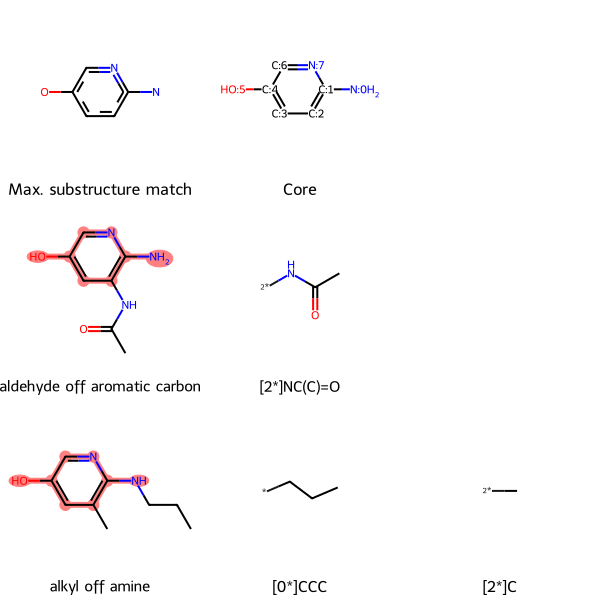

In [4]:
ms = {'c1c(O)cnc(N)c(NC(=O)(C))1': 'aldehyde off aromatic carbon', 'c1c(O)cnc(N(CCC))c1(C)': 'alkyl off amine'}
SmilesMCStoGridImage(ms, groups=True)

The core's atoms are numbered, and each groups is labeled with the core atom that it is attached to.

For example, in the second row, the aldehyde off aromatic carbon molecule's only group off the core is [2*]NC(C)=0. This notation means that the group is attached to atom 2 on the core (the carbon atom at the bottom right of the aromatic ring) at the group's nitrogen atom.

In the third row, alkyl off amine, has two groups off the core. The first, `[0*]CCC`, is a propyl group attached to core atom 0 (the amine nitrogen off the ring) at a terminal carbon atom. The second group, `[2*]C`, is a methyl group attached to atom 2 on the core (the carbon atom at the bottom right of the aromatic ring).

Returning to the lead optimization context, if an assay revealed improved bioactivity of the aldehyde and alkyl compared to the core, we might want to make variations that incorporate the additional groups of each molecule. 

## Larger Example: Five Pyridinols

Here's an example of a larger set of molecules, where the numbered molecules correspond to those from [Shchepin et al](https://pubmed.ncbi.nlm.nih.gov/24482730/). For larger sets of molecules, I recommend passing in the flag `useSVG=True`, which will direct RDKit's [`Draw.MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) to output the image as an SVG. That makes small features such as the atom labels easy to read upon zooming in because [Scalable Vector Graphics](https://en.wikipedia.org/wiki/Scalable_Vector_Graphics) is, as the name states, a vector format.

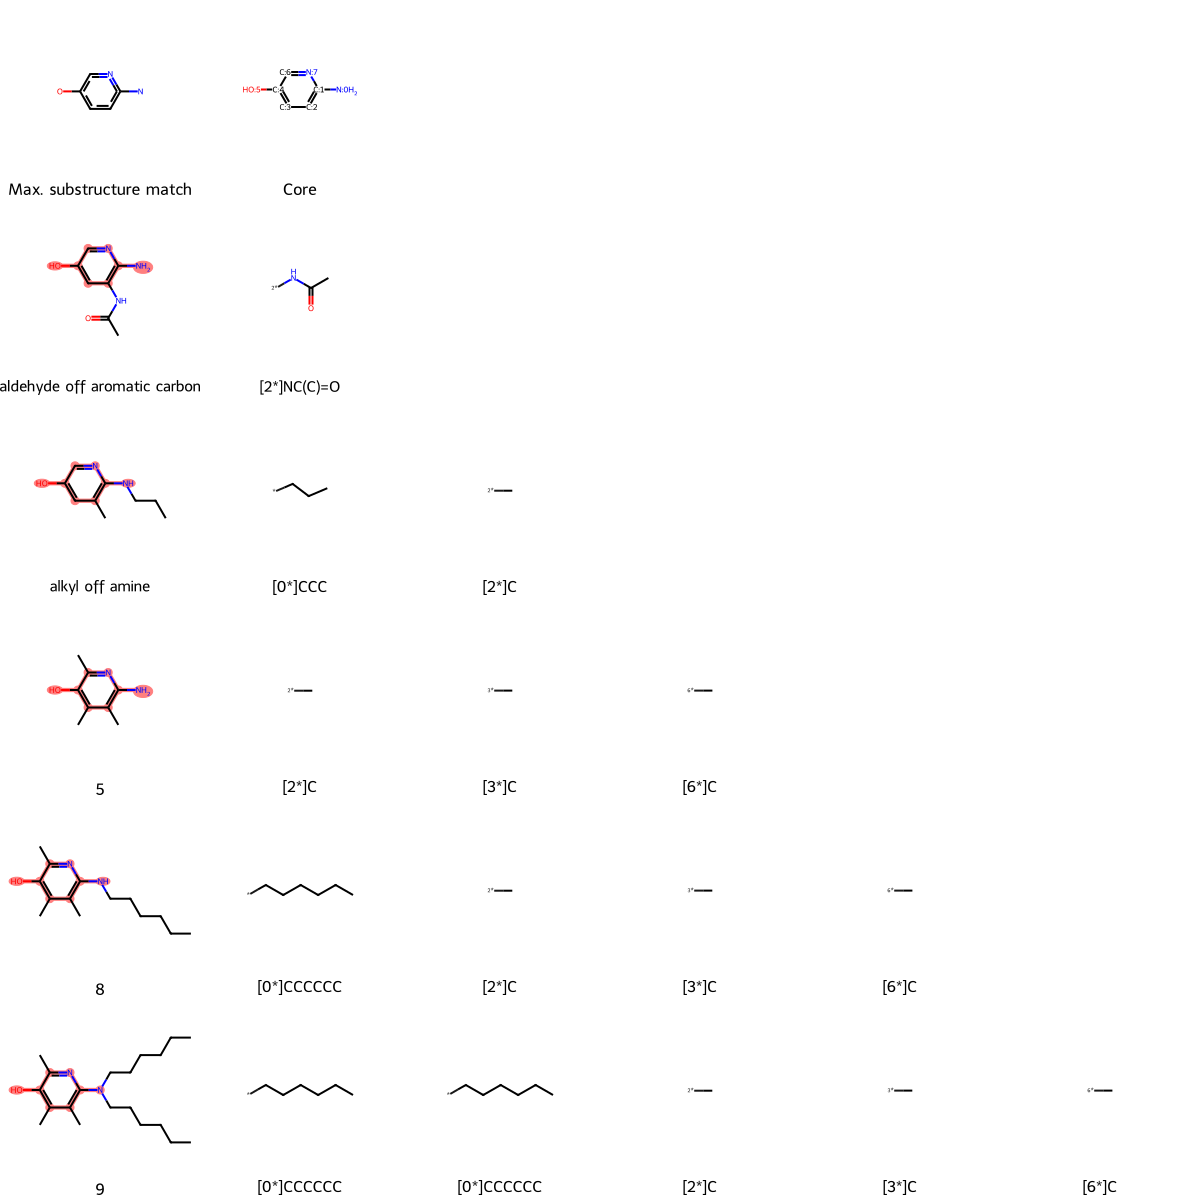

In [5]:
ms_more = {'c1c(O)cnc(N)c(NC(=O)(C))1': 'aldehyde off aromatic carbon', 'c1c(O)cnc(N(CCC))c1(C)': 'alkyl off amine', 'c1(C)c(O)c(C)nc(N)c1(C)': '5', 'c1(C)c(O)c(C)nc(N(CCCCCC))c1(C)': '8', 'c1(C)c(O)c(C)nc(N(CCCCCC)(CCCCCC))c1(C)': '9'}
SmilesMCStoGridImage(ms_more, groups=True, useSVG=True)

If assays revealed increased toxicity in the "alkyl off amine", #8, and #9 molecules, we might infer that having an alkyl group off the amine nitrogen is detrimental, and thus focus on molecules without that feature.

## Get Additional Data

If you want `SmilesMCStoGridImage` to return not just the grid image, but also the substructure match and molecule, plus the SMILES strings for the molecules and groups, and the core SMILES and molecule, set `verbose=True`:

In [6]:
ms = {'c1c(O)cnc(N)c(NC(=O)(C))1': 'aldehyde off aromatic carbon', 'c1c(O)cnc(N(CCC))c1(C)': 'alkyl off amine'}
drawing, mcs_smarts, mcs_mol, mols_2D, core_smiles, core_mol = SmilesMCStoGridImage(ms, groups=True, verbose=True)

You then must explicitly call the image to draw it:

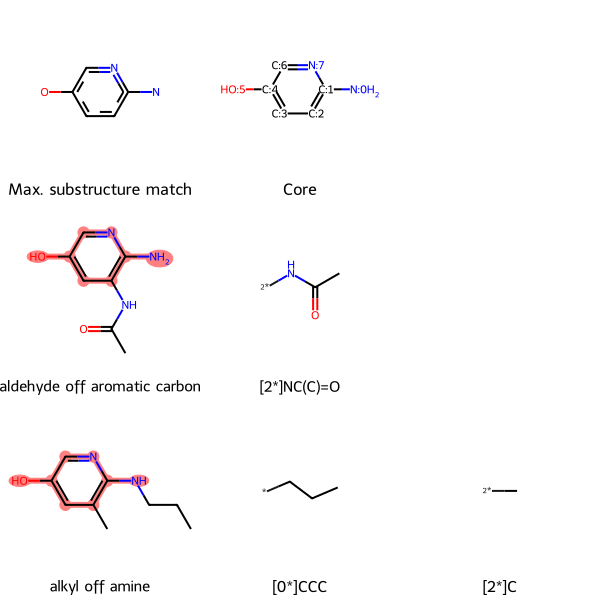

In [7]:
drawing

`mcs_smarts` is the SMARTS match string for the maximum common substructure (MCS):

In [8]:
mcs_smarts

'[#6]1:[#6](-[#8]):[#6]:[#7]:[#6](:[#6]:1)-[#7]'

`mcs_mol` is the molecular representation of that MCS:

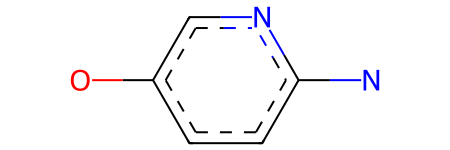

In [9]:
mcs_mol

`mols_2D` is the nested list of input molecules and groups, where each sub-list represents an input molecule:

In [10]:
mols_2D

[[<rdkit.Chem.rdchem.Mol at 0x169824120>,

`core_smiles` is the SMILES string of the core that groups are off of:

In [11]:
core_smiles

'Nc1ccc(O)cn1'

`core_mol` is the RDKit molecule for the core:

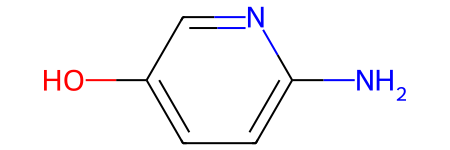

In [12]:
core_mol

## Edge Case: There is No MCS

If you input a set of molecules that has no MCS, there is no core to locate groups off of, so `SmilesMCStoGridImage` will
- notify you and effectively ignore `groups=True`
- give the same result as if you had set `groups=False` or not included the `groups` flag at all (because its default is `False`):

There is no maximum common substructure (MCS), so groups off the MCS cannot be created. This output reflects groups=False. If you want to find groups, please ensure the set of molecules has an MCS.


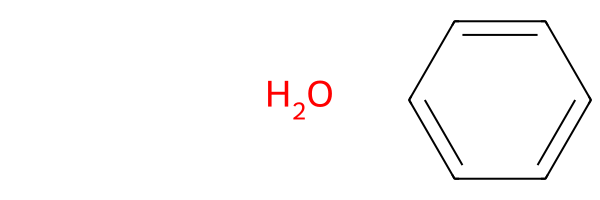

In [13]:
SmilesMCStoGridImage(["O", "c1ccccc1"], groups=True)

### Using `groups` and `verbose` Equal `True` If There is No MCS

A call using `groups=True` and `verbose=True` when there is no MCS will not throw an exception; instead, `SmilesMCStoGridImage` will return values as if you had not set `groups=True`. As a result, you will not get a confusing exception about having an incorrect number of arguments to unpack.

In [14]:
drawing_no_mcs, mcs_smarts_no_mcs, mcs_mol_no_mcs, mols_2D_no_mcs, core_smiles_no_mcs, core_mol_no_mcs = SmilesMCStoGridImage(["O", "c1ccccc1"], groups=True, verbose=True)

There is no maximum common substructure (MCS), so groups off the MCS cannot be created. This output reflects groups=False. If you want to find groups, please ensure the set of molecules has an MCS.


The drawing is the same as if you had not set `groups=True`:

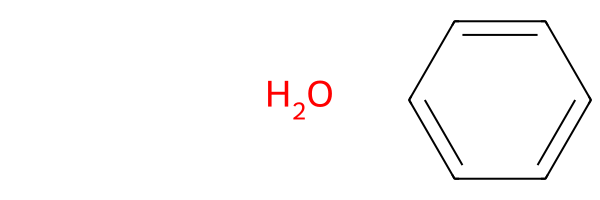

In [15]:
drawing_no_mcs

You will get "empty" values for `mcs_smarts`, `mcs_mol`, `core_smiles`, and `core_mol`:

In [16]:
mcs_smarts_no_mcs

''

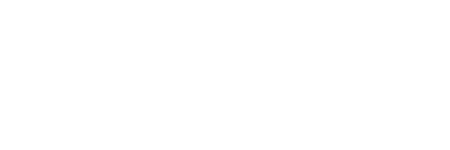

In [17]:
mcs_mol_no_mcs

In [18]:
core_smiles_no_mcs

''

In [19]:
core_mol_no_mcs

And mols_2D will revert to the one-dimensional list of input molecules:

In [20]:
mols_2D_no_mcs

## Notes

For more information about the other parameters in `SmilesMCStoGridImage`, refer to my original blog post [Find and Highlight the Maximum Common Substructure Between a Set of Molecules Using RDKit]({% post_url 2022-10-09-RDKit-find-and-highlight-the-maximum-common-substructure-between-molecules %})

Thanks to [Greg Landrum](https://github.com/greglandrum) for suggesting this scheme to find groups off of a common core, and to [Brian Kelley](https://github.com/bp-kelley) for clarifying the RDKit's atom numbering scheme for [`ReplaceCore`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.ReplaceCore).